# ML Cup Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.network import NeuralNetwork
from model.trainer import Trainer
from model.losses import Loss, mee
from utils import DataLoader
from utils import plot_curves
from utils import StandardScaler
from utils.model_selection_helpers import instability_coeff, tran_val_diff, count_parameters
from utils.grid_search import grid_search_mlcup
from IPython.display import clear_output

np.random.seed(8)

In [2]:
# Load Data
PATH = 'data/ML CUP/ML-CUP25-TR.csv'
df = pd.read_csv(PATH, comment='#', header=None)

dataset = np.array(df)
X = dataset[:, 1:-4]
y = dataset[:, -4:]

print(f"X.shape: {X.shape}, y.shape: {y.shape} ")
train_test_dataset = DataLoader(X, y)
X_train, y_train, X_test, y_test = train_test_dataset.train_val_split(portion = 0.8, shuffle = True)
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")
train_val_dataset = DataLoader(X_train, y_train)

X.shape: (500, 12), y.shape: (500, 4) 
X_train.shape: (400, 12), y_train.shape: (400, 4), X_test.shape: (100, 12), y_test.shape: (100, 4)


In [3]:
# All the configurations to test for the training
# Neural Network architectures
INPUT_NEURONS = 12
OUTPUT_NEURONS = 4

HIDDEN_LAYER_SIZES = [8, 16, 32]
HIDDEN_LAYERS_COUNTS = [1, 2]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('identity', 'mse')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

# Training parameters
ETA_CONFIGURATIONS =[0.1, ]
LAMBDA_CONFIGURATIONS =[1e-4, ] # we have to make them small because they are independent of eta
ALPHA_CONFIGURATIONS = [0.5, 0.9]
BATCH_SIZES =  [64, 128] 

# Cross-validation parameters
K_FOLDS= 5
EPOCHS = 250
EARLY_STOPPING_PATIENCE = 50

# All possible configurations are tuples (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        for BATCH_SIZE in BATCH_SIZES:
            config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE)
            CONFIGURATIONS.append(config)
LEN_CONFIGURATIONS = len(CONFIGURATIONS)

print(f"Total configurations: {LEN_CONFIGURATIONS}")

Total configurations: 72


In [4]:
def print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_DICTIONARY_TEST_LOSS, min_mee = 100.0):
    # print the top 25 configurations, sorting criterias: 1 avg mee
    #sometimes gradient explodes and mee is nan
    valid_id = []
    for i in CONFIG_DICTIONARY:
        if not np.isnan(CONFIG_DICTIONARY[i]):
            valid_id.append(i)
            
    TOP_25_CONFIGS_INDEXES = sorted(valid_id, key=lambda i: (max(min_mee, CONFIG_DICTIONARY[i] / K_FOLDS), CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i],count_parameters(CONFIGURATIONS[i][0]), CONFIG_DICTIONARY_INSTABILITY_VAL[i]))[:25]
    print("Top 25 configurations:")
    for i in TOP_25_CONFIGS_INDEXES:
        MEE = CONFIG_DICTIONARY[i]/ K_FOLDS
        print(f'''Config index: {CONFIGURATIONS[i]}, Avg Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS}, Mean MEE: {MEE}%,
            training instability coeff validation: {CONFIG_DICTIONARY_INSTABILITY_VAL[i] / K_FOLDS}, 
            training instability coeff train: {CONFIG_DICTIONARY_INSTABILITY_TRAIN[i] / K_FOLDS}, 
            training loss-val loss diff: {CONFIG_DICTIONARY_TRAIN_LOSS_DIFF[i] / K_FOLDS}, 
            Mean Epochs: {CONFIG_DICTIONARY_EPOCHS[i] // K_FOLDS},
            Mean Test Loss (not rescaled): {np.mean(CONFIG_DICTIONARY_TEST_LOSS[i])},
            Std Test Loss (not rescaled): {np.std(CONFIG_DICTIONARY_TEST_LOSS[i])}
            ''')

## Neural Network for classification

In [5]:
k_fold = train_val_dataset.k_fold(k = K_FOLDS)
grid_s_outputs =  grid_search_mlcup(LEN_CONFIGURATIONS, CONFIGURATIONS, k_fold, EPOCHS, EARLY_STOPPING_PATIENCE)
CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_DICTIONARY_TEST_LOSS = grid_s_outputs
clear_output(wait=False)
print_top_25(CONFIG_DICTIONARY, CONFIG_DICTIONARY_EPOCHS, CONFIG_DICTIONARY_INSTABILITY_TRAIN, CONFIG_DICTIONARY_INSTABILITY_VAL, CONFIG_DICTIONARY_TRAIN_LOSS_DIFF, CONFIG_DICTIONARY_TEST_LOSS, min_mee= 23.0) ## if many NN have MEE , 23 -> we choose the most stableML_Cup_internal_test.ipynb

Top 25 configurations:
Config index: ([12, 8, 8, 4], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.001, 0.0001, 0.9, 128), Avg Epochs: 250, Mean MEE: 25.200362436439214%,
            training instability coeff validation: 0.0036894607487348427, 
            training instability coeff train: 1.7502562725119581, 
            training loss-val loss diff: 6.035439515729179, 
            Mean Epochs: 250,
            Mean Test Loss (not rescaled): 0.6475191838761913,
            Std Test Loss (not rescaled): 0.023946010167177446
            
Config index: ([12, 8, 4], ['leaky relu', 'identity'], 'mse', 0.001, 0.0001, 0.9, 64), Avg Epochs: 250, Mean MEE: 25.30534938518778%,
            training instability coeff validation: 0.0044821723748192524, 
            training instability coeff train: 0.00010596882427609166, 
            training loss-val loss diff: 4.737842452662574, 
            Mean Epochs: 250,
            Mean Test Loss (not rescaled): 0.6423356652978367,
            Std Te

## Internal Test

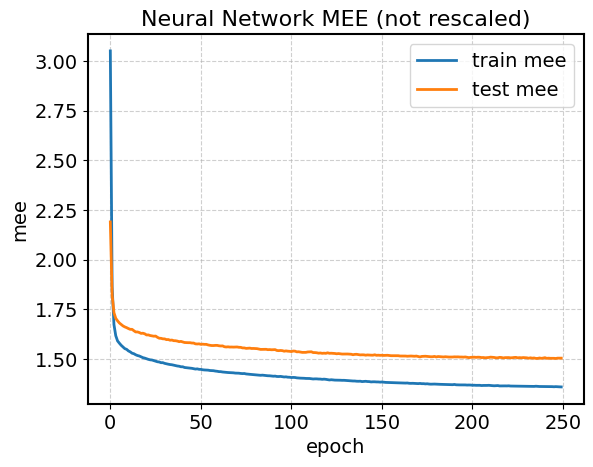

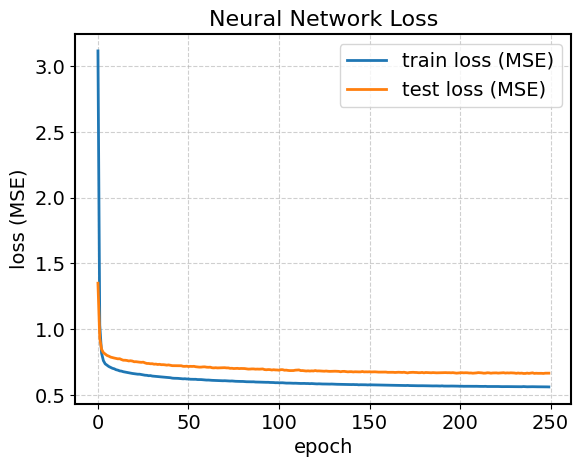

Train MEE: 23.330290415065633
Test MEE: 25.55719876642133


In [8]:
### chosen configuration
'''Config index: ([12, 32, 4], ['relu', 'identity'], 'mse', 0.001, 0.0001, 0.9, 64), Avg Epochs: 164, Mean MEE: 21.960007052590793%,
            training instability coeff validation: 6.345182397467081, 
            training instability coeff train: 1.6182371515598581, 
            training loss-val loss diff: 15.633324404887933, 
            Mean Epochs: 164,
            Mean Test Loss (not rescaled): 0.47513341866662573,
            Std Test Loss (not rescaled): 0.03454318930158234
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE =[12, 32, 32, 4], ['leaky relu', 'leaky relu', 'identity'], 'mse', 0.001, 0.01, 0.5, 16
EPOCHS = 250

#scaling
X_scaler = StandardScaler(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_val_scaled = y_scaler.transform(y_test)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    X_val = X_val_scaled,
    y_val=y_val_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=False, plot_mee= True, plot_title = 'Neural Network MEE (not rescaled)')

#plot curves
plot_curves(np.array(train_loss_vector), np.array(test_loss_vector), 'loss (MSE)', 'test', title = 'Neural Network Loss', save_plots=True)

# Train MAE
out = nn.forward(X_train_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
train_loss = mee(y_train, out)
print(f"Train MEE: {np.mean(train_loss)}")

# Test MAE
out = nn.forward(X_val_scaled)[-1][-1]  #have to use the last trained nn, otherwise is data leakage
out = y_scaler.inverse_transform(out)

test_loss = mee(y_test, out)
print(f"Test MEE: {np.mean(test_loss)}")

## Final Submission

In [8]:
# Load Data
PATH_TR = 'data/ML CUP/ML-CUP25-TR.csv'
PATH_TS = 'data/ML CUP/ML-CUP25-TS.csv'

df = pd.read_csv(PATH_TR, comment='#', header=None)

dataset = np.array(df)
X_tr = dataset[:, 1:-4]
y = dataset[:, -4:]

df = pd.read_csv(PATH_TS, comment='#', header=None)

dataset = np.array(df)
X_ts = dataset[:, 1:]

print(f"X_tr.shape: {X_tr.shape}, y.shape: {y.shape},  X_ts.shape: {X_ts.shape}")
dataset = DataLoader(X_tr, y)

X_tr.shape: (500, 12), y.shape: (500, 4),  X_ts.shape: (1000, 12)


In [9]:
### chosen configuration
'''Config index: ([12, 32, 4], ['relu', 'identity'], 'mse', 0.001, 0.0001, 0.9, 64), Avg Epochs: 164, Mean MEE: 21.960007052590793%,
            training instability coeff validation: 6.345182397467081, 
            training instability coeff train: 1.6182371515598581, 
            training loss-val loss diff: 15.633324404887933, 
            Mean Epochs: 164,
            Mean Test Loss (not rescaled): 0.47513341866662573,
            Std Test Loss (not rescaled): 0.03454318930158234
'''

# Choose the best configuration and train it on the full training set, evaluate on the test set
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA, BATCH_SIZE =[12, 32, 4], ['relu', 'identity'], 'mse', 0.001, 0.0001, 0.9, 64
EPOCHS = 164 - EARLY_STOPPING_PATIENCE

#scaling
X_scaler = StandardScaler(X_tr)
X_train_scaled = X_scaler.transform(X_tr)
X_val_scaled = X_scaler.transform(X_ts)
y_scaler = StandardScaler(y)
y_train_scaled = y_scaler.transform(y)

#training
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_scaled,
    y_train=y_train_scaled,
    epochs=EPOCHS,
    early_stopping=EPOCHS + 1, #can't early stop because we are using the test set as final evaluation, the +1 is to be extra sure
    eta=ETA,                   # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=BATCH_SIZE,
    shuffle_batches=True
)
# still returns the best nn, but we don-t use it for accuracy calculation nor early stopping otherwise it is data leakage
best_nn, train_loss_vector, test_loss_vector = trainer.train(print_epochs=True)

# Train MAE
out = nn.forward(X_val_scaled)[-1][-1] 
out = y_scaler.inverse_transform(out)
print(out.shape)

epoch 0 ---------------------
train loss: 2.0968966706339542
epoch 1 ---------------------
train loss: 1.146129976991471
epoch 2 ---------------------
train loss: 0.7239707870795891
epoch 3 ---------------------
train loss: 0.713571886551394
epoch 4 ---------------------
train loss: 0.7209794770307714
epoch 5 ---------------------
train loss: 0.692106375662335
epoch 6 ---------------------
train loss: 0.6764408738349466
epoch 7 ---------------------
train loss: 0.6681825309560571
epoch 8 ---------------------
train loss: 0.6647433658910626
epoch 9 ---------------------
train loss: 0.665747279855073
epoch 10 ---------------------
train loss: 0.6614233825384142
epoch 11 ---------------------
train loss: 0.6585011520779637
epoch 12 ---------------------
train loss: 0.6534114716074436
epoch 13 ---------------------
train loss: 0.6541146668452986
epoch 14 ---------------------
train loss: 0.6508290519664357
epoch 15 ---------------------
train loss: 0.6473841595342682
epoch 16 -------------

In [10]:
# nome team "Fraleli"
# membri "Alessandro Tesi, Elia Bocini, Francesco Fiaschi"
# data = "21/01/2026"

df_submission = pd.DataFrame(out)
df_submission.index = df_submission.index + 1  #adjust index to follow cup 25 csv
df_submission.to_csv('FRALELI_ML-CUP25-TS.csv') ### RICORDATI DI AGGIUNGERE I COMMENTI